In [1]:
import re
import pandas as pd
from collections import defaultdict

# sumy
from __future__ import absolute_import
from __future__ import division, print_function, unicode_literals
 
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.nlp.stemmers import Stemmer
from sumy.utils import get_stop_words
from sumy.summarizers.edmundson import EdmundsonSummarizer

# NLTK stopwords
from nltk.corpus import stopwords

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Set Pandas to display all rows of dataframes
pd.set_option('display.max_rows', 500)

In [2]:
books = ["data/Rowling, J.K. - HP 1 - Harry Potter and the Sorcerer's Stone.txt",
         "data/Rowling, J.K. - HP 2 - Harry Potter and the Chamber of Secrets.txt",
         "data/Rowling, J.K. - HP 3 - Harry Potter and the Prisoner of Azkaban.txt",
         "data/Rowling, J.K. - HP 4 - Harry Potter and the Goblet of Fire.txt",
         "data/Rowling, J.K. - HP 5 - Harry Potter and the Order of the Phoenix.txt",
         "data/Rowling, J.K. - HP 6 - Harry Potter and the Half-Blood Prince.txt",
         "data/Rowling, J.K. - HP 7 - Harry Potter and the Deathly Hallows.txt"]

In [3]:
pattern = ("(C H A P T E R [A-Z -]+)" +                  # Group 1 selects the chapter number
           "\n+([A-Z \n',.-]+)\\b(?![A-Z]+(?=\.)\\b)" +  # Group 2 selects the chapter title but excludes edgs of all caps word beginning first sentence of the chapter
           "(?![a-z']|[A-Z.])" +                         # chapter title ends with lowercase letters or a period
           "(.*?)" +                                     # Group 3 selects the chapter contents
           "(?=C H A P T E R|This book)")                # chapter contents ends with a new chapter or the end of book
hp = defaultdict(dict)
cnt = 0
for book in books:
    title = book[28:-4]
    with open(book, 'r') as f:
        text = f.read().replace('&rsquo;',"'")
    chapters = re.findall(pattern, text, re.DOTALL)
    chap = 0
    for chapter in chapters:
        chap += 1
        chap_title = chapter[1].replace('\n','')
        chap_text = (chapter[2][3:].replace('&ldquo;', '"')
                                   .replace('&rdquo;', '"')
                                   .replace('&mdash;', '—'))
        chap_text = re.sub('\n*&bull; [0-9]+ &bull; \n*' + chap_title + ' \n*', '', chap_text, flags=re.IGNORECASE)
        chap_text = re.sub('\n*&bull; [0-9]+ &bull; \s*CHAPTER [A-Z]+ \s*', '', chap_text)
        chap_text = re.sub(' \n&bull; [0-9]+ &bull; \n*', '', chap_text)
        chap_text = re.sub('\n+', '\n', chap_text)
        hp[title]['Chapter ' + str(chap)] = (chap_title, chap_text)
hp = dict(hp)

### The format of the Harry Potter hp dictionary is as follows:
#### The first book is 'hp1', second is 'hp2', etc.
&nbsp;   
{'hp1': {  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 1': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 2': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 3': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ...  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; }  
 'hp2': {  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 'Chapter 1': (chapter title, chapter text),  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; ...  
         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; }  
 &nbsp;...  
}  

In [4]:
stop_words = stopwords.words('english')

In [5]:
# Convert to list
data = [hp[book][chapter][1].replace('\n', '') for book in hp for chapter in hp[book]]

In [6]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [7]:
data_words = list(sent_to_words(data))

In [8]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [9]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [10]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [12]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '~/mallet-2.0.8/bin/mallet' # update this path

In [17]:
def compute_coherence_values(dictionary, corpus, texts, stop, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        print('Calculating {}-topic model'.format(num_topics))
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [19]:
# Can take a long time to run.
start=5; stop=25; step=1;
model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=data_lemmatized,
                                                        start=start,
                                                        stop=stop + 1,
                                                        step=step)

Calculating 5-topic model
Calculating 6-topic model
Calculating 7-topic model
Calculating 8-topic model
Calculating 9-topic model
Calculating 10-topic model
Calculating 11-topic model
Calculating 12-topic model
Calculating 13-topic model
Calculating 14-topic model
Calculating 15-topic model
Calculating 16-topic model
Calculating 17-topic model
Calculating 18-topic model
Calculating 19-topic model
Calculating 20-topic model
Calculating 21-topic model
Calculating 22-topic model
Calculating 23-topic model
Calculating 24-topic model


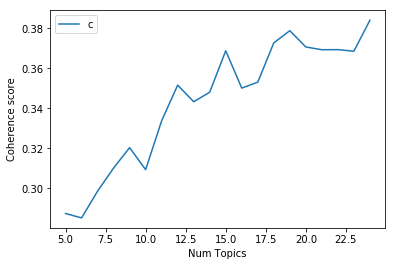

In [21]:
# Show graph
x = range(start, stop, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [23]:
# Print the coherence scores
idx = 0
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 6), '  Model index', idx)
    idx += 1

Num Topics = 5  has Coherence Value of 0.287494   Model index 0
Num Topics = 6  has Coherence Value of 0.285283   Model index 1
Num Topics = 7  has Coherence Value of 0.298659   Model index 2
Num Topics = 8  has Coherence Value of 0.310209   Model index 3
Num Topics = 9  has Coherence Value of 0.320389   Model index 4
Num Topics = 10  has Coherence Value of 0.309396   Model index 5
Num Topics = 11  has Coherence Value of 0.333835   Model index 6
Num Topics = 12  has Coherence Value of 0.351619   Model index 7
Num Topics = 13  has Coherence Value of 0.343324   Model index 8
Num Topics = 14  has Coherence Value of 0.348087   Model index 9
Num Topics = 15  has Coherence Value of 0.368809   Model index 10
Num Topics = 16  has Coherence Value of 0.350137   Model index 11
Num Topics = 17  has Coherence Value of 0.353111   Model index 12
Num Topics = 18  has Coherence Value of 0.372732   Model index 13
Num Topics = 19  has Coherence Value of 0.378829   Model index 14
Num Topics = 20  has Cohe

In [24]:
# Select the model and print the topics
index = 14
optimal_model = model_list[index]
model_topics = optimal_model.show_topics(formatted=False)

In [25]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [26]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['document_number', 'dominant_topic', 'topic_percent_contribution', 'keywords', 'text']

In [27]:
bonus_words = [text.split(', ') for text in df_dominant_topic['keywords'].tolist()]

In [28]:
def summarize(text, sentence_count, bonus_words, language='english'):
    summarizer = EdmundsonSummarizer(Stemmer(language))
    summarizer.stop_words = get_stop_words(language)
    summarizer.bonus_words = bonus_words
    summarizer.stigma_words = ['zdfgthdvndadv']
    summarizer.null_words = stopwords.words('english')
    summary = summarizer(PlaintextParser(text, Tokenizer(language)).document, sentence_count)
    return summary

In [29]:
def print_summary(summary):
    for sentence in summary:
        print(sentence)

In [31]:
doc = 0
for book in hp:
    print(book)
    for chapter in hp[book]:
        print('{} - {}'.format(chapter, hp[book][chapter][0]))
        words = bonus_words[doc]
        # split up bigrams used in LDA model
        words = [item for sublist in [item.split('_') for item in words] for item in sublist]
        words.extend(hp[book][chapter][0].lower().split())
        print(words)
        print_summary(summarize(hp[book][chapter][1], 5, words))
        doc += 1
        print()
    print()

Harry Potter and the Sorcerer's Stone
Chapter 1 - THE BOY WHO LIVED
['harry', 'dudley', 'dursley', 'letter', 'aunt', 'petunia', 'house', 'owl', 'car', 'boy', 'school', 'the', 'boy', 'who', 'lived']
At half past eight, Mr. Dursley picked up his briefcase, pecked Mrs. Dursley on the cheek, and tried to kiss Dudley good-bye but missed, because Dudley was now having a tantrum and throwing his cereal at the walls.
When Dudley had been put to bed, he went into the living room in time to catch the last report on the evening news: "And finally, bird-watchers everywhere have reported that the nation's owls have been behaving very unusually today.
Twelve times he clicked the Put-Outer, until the only lights left on the whole street were two tiny pinpricks in the distance, which were the eyes of the cat watching him.
One small hand closed on the letter beside him and he slept on, not knowing he was special, not knowing he was famous, not knowing he would be woken in a few hours' time by Mrs. Durs

At three-thirty that afternoon, Harry, Ron, and the other Gryffindors hurried down the front steps onto the grounds for their first flying lesson.
It was a clear, breezy day, and the grass rippled under their feet as they marched down the sloping lawns toward a  smooth, flat lawn on the opposite side of the grounds to the forbidden forest, whose trees were swaying darkly in the distance.
Harry saw his scared white face look down at the ground falling away, saw him gasp, slip sideways off the broom and — WHAM — a thud and a nasty crack and Neville lay facedown on the grass in a heap.
All the same, it wasn't what you'd call the perfect end to the day, Harry thought, as he lay awake much later listening to Dean and Seamus falling asleep (Neville wasn't back from the hospital wing).
Harry yelled, and the four of them sprinted down the gallery, not looking back to see whether Filch was following — they swung around the doorpost and galloped down one corridor then another, Harry in the lead,

For the first time, a spasm of fear flitted across Quirrell's face.
Where there should have been a back to Quirrell's head, there was a face, the most terrible face Harry had ever seen.
At once, a needle-sharp pain seared across Harry's scar; his head felt as though it was about to split in two; he yelled, struggling with all his might, and to his surprise, Quirrell let go of him.
The two things most human beings would choose above all — the trouble is, humans do have a knack of choosing precisely those things that are worst for them."
And suddenly, their wardrobes were empty, their trunks were packed, Neville's toad was found lurking in a corner of the toilets; notes were handed out to all students, warning them not to use magic over the holidays ("I always hope they'll forget to give us these," said Fred Weasley sadly); Hagrid was there to take them down to the fleet of boats that sailed across the lake; they were boarding the Hogwarts Express; talking and laughing as the countryside

Stuffing the parchment back into the envelope, Harry threw it back onto the desk just as the door opened.
Harry was at the point of telling Ron and Hermione about Filch  and the Kwikspell course when the salamander suddenly whizzed into the air, emitting loud sparks and bangs as it whirled wildly round the room.
The sight of Percy bellowing himself hoarse at Fred and George, the spectacular display of tangerine stars showering from the salamander's mouth, and its escape into the fire, with accompanying explosions, drove both Filch and the Kwikspell envelope from Harry's mind.
The rest of the school was happily anticipating their Halloween feast; the Great Hall had been decorated with the usual live bats, Hagrid's vast pumpkins had been carved into lanterns large enough for three men to sit in, and there were rumors that Dumbledore had booked a troupe of dancing skeletons for the entertainment.
From either end of the corridor where they stood came the sound of hundreds of feet climbing 

Preferring not to answer that question, Harry said, "There are good things in there, too.
But Lockhart's disgusting cheeriness, his hints that he had always thought Hagrid was no good, his confidence that the whole business was now at an end, irritated Harry so much that he yearned to throw Gadding with Ghouls right in Lockhart's stupid face.
Harry said to Ron, whose eyes he could just make out, reflecting the light from his wand.
Harry could hear Fang fighting to free himself from a third monster, whining loudly, but Harry couldn't have yelled even if he had wanted to; he seemed to have left his voice back with the car in the clearing.
Aragog clicked his pincers furiously, and all around the hollow the sound was echoed by the crowd of spiders; it was like applause, except applause didn't usually make Harry feel sick with fear.

Chapter 16 - THE CHAMBER OF SECRETS
['harry', 'snape', 'professor', 'mcgonagall', 'potter', 'filch', 'lockhart', 'open', 'slytherin', 'school', 'corridor', 'th

Puffing loudly, Harry, Ron, and Hermione climbed the tightly spiraling steps, getting dizzier and dizzier, until at last they heard the murmur of voices above them and knew they had reached the classroom.
Innumerable chains and beads hung around her spindly neck, and her arms and hands were encrusted with bangles and rings.
The book tried to bite, but Hagrid ran a giant forefinger down its spine, and the book shivered, and then fell open and lay quiet in his hand.
They had the bodies, hind legs, and tails of horses, but the front legs, wings, and heads of what seemed to be  giant eagles, with cruel, steel-colored beaks and large, brilliantly orange eyes.
It was nothing like a broomstick, and Harry knew which one he preferred; the hippogriff 's wings beat uncomfortably on either side of him, catching him under his legs and making him feel he was about to be thrown off; the glossy feathers slipped under his fingers and he didn't dare get a stronger grip; instead of the smooth action of h

In a last-ditch attempt to cheer Ron up, Harry persuaded him to come along to the Gryffindor team's final practice before the Ravenclaw match, so that he could have a ride on the Firebolt after they'd finished.
three — two — one —" Harry kicked off into the air and the Firebolt zoomed higher and faster than any other broom; he soared around the stadium and began squinting around for the Snitch, listening all the while to the commentary, which was being provided by the Weasley twins' friend Lee Jordan.
According to Which Broomstick, the Firebolt's going to be the broom of choice for the national teams at this year's World Championship —" "Jordan, would you mind telling us what's going on in the match?"
Ravenclaw was pulling back; they had now scored three goals, which put Gryffindor only fifty points ahead — if Cho got the Snitch before him, Ravenclaw would win.
Harry dropped lower, narrowly avoiding a Ravenclaw Chaser, scanning the field frantically — a glint of gold, a flutter of tiny

"Professor Dumbledore, Sirius Black —" "For heaven's sake!"
"Now, Snape," said Fudge, startled, "the young lady is disturbed in her mind, we must make allowances —" "I would like to speak to Harry and Hermione alone," said Dumbledore abruptly.
"Professor, Black's telling the truth — we saw Pettigrew —"CHAPTER TWENTY-ONE "— he escaped when Professor Lupin turned into a werewolf —" "— he's a rat —" "— Pettigrew's front paw, I mean, finger, he cut it off —" "— Pettigrew attacked Ron, it wasn't Sirius —" But Dumbledore held up his hand to stem the flood of explanations.
"Professor Lupin can tell you —" Harry said, unable to stop himself.
He explained what he'd seen; how, as the nearest dementor had lowered its mouth to Harry's, a large silver something had come galloping across the lake and forced the dementors to retreat.

Chapter 22 - OWL POST AGAIN
['harry', 'back', 'face', 'hear', 'time', 'find', 'make', 'thing', 'good', 'eye', 'owl', 'post', 'again']
Harry!"
As the lock clicked behind

Mrs. Weasley was stirring the contents of a large pot on the stove, while Mr. Weasley was sitting at the table, checking a sheaf of large parchment tickets.
Mrs. Weasley was still glowering as she kissed Mr. Weasley on the cheek, though not nearly as much as the twins, who had each hoisted their rucksacks onto their backs and walked out without a word to her.
"I'll send Bill, Charlie, and Percy along around midday," Mrs. Weasley said to Mr. Weasley, as he, Harry, Ron, Hermione, and Ginny set off across the dark yard after Fred and George.
"Now we just need the Portkey," said Mr. Weasley, replacing his glasses and squinting around at the ground.
His feet left the ground; he could feel Ron and Hermione on either side of him, their shoulders banging into his; they were all speeding forward in a howl of wind and swirling color; his forefinger was stuck to the boot as though it was pulling him magnetically onward and then — His feet slammed into the ground; Ron staggered into him and he fel

The storm had blown itself out by the following morning, though the ceiling in the Great Hall was still gloomy; heavy clouds of pewter gray swirled overhead as Harry, Ron, and Hermione examined their new course schedules at breakfast.
When the bell rang to signal the start of afternoon lessons, Harry and Ron set off for North Tower where, at the top of a tightly spiraling staircase, a silver stepladder led to a circular trapdoor in the ceiling, and the room where Professor Trelawney lived.
"Good day," said the misty voice of Professor Trelawney right behind Harry, making him jump.
But Hermione was right, Harry thought irritably, Professor Trelawney really was an old fraud.
It seems as though the Ministry of Magic's troubles are not yet at an end, writes Rita Skeeter, Special Correspondent.

Chapter 14 - THE UNFORGIVABLE CURSES
['hermione', 'umbridge', 'harry', 'class', 'professor', 'trelawney', 'voice', 'lesson', 'cho', 'day', 'bag', 'the', 'unforgivable', 'curses']
"Years back, there 

By the time Harry reached the bottom of the marble staircase, Cedric was at the top.
She was leading him toward the place where the dragons were, around the edge of the forest, but when they approached the clump of trees behind which the enclosure would be clearly visible, Harry saw that a tent had been erected, its entrance facing them, screening the dragons from view.
Harry soared higher in a circle; the Horntail was still following his progress; its head revolving on its long neck — if he kept this up, it would be nicely dizzy — but better not push it too long, or it would be breathing fire again — Harry plummeted just as the Horntail opened its mouth, but this time he was less lucky — he missed the flames, but the tail came whipping up to meet him instead, and as he swerved to the left, one of the long spikes grazed his shoulder, ripping his robes — He could feel it stinging, he could hear screaming and groans from the crowd, but the cut didn't seem to be deep.
Before the dragon kn

Hermione squashed this plan by pointing out that, in the unlikely event that Harry managed to learn how to operate an Aqua-Lung within the set limit of an hour, he was sure to be disqualified for breaking the International Code of Wizarding Secrecy — it was too much to hope that no Muggles would spot an Aqua-Lung zooming across the countryside to Hogwarts.
The excited babble of the crowd echoed strangely across the water as Harry ran flat-out around the other side of the lake toward the judges, who were sitting at another gold-draped table at the water's edge.
The whistle echoed shrilly in the cold, still air; the stands erupted with cheers and applause; without looking to see what the other champions were doing, Harry pulled off his shoes and socks, pulled the handful of gillyweed out of his pocket, stuffed it into his mouth, and waded out into the lake.
The shark-man swam straight to Hermione and began snapping and biting at her ropes; the trouble was that Krum's new teeth were posit

Voldemort bent down and pulled out Wormtail's left arm; he forced the sleeve of Wormtail's robes up past his elbow, and Harry saw something upon the skin there, something like a vivid red tattoo — a skull with a snake protruding from its mouth — the image that had appeared in the sky at the Quidditch World Cup: the Dark Mark.
The Death Eaters behind him did the same; each of them approaching Voldemort on his knees and kissing his robes, before backing away and standing up, forming a silent circle, which enclosed Tom Riddle's grave, Harry, Voldemort, and the sobbing and twitching heap that was Wormtail.
The Death Eater on the ground writhed and shrieked; Harry was sure the sound must carry to the houses around.
The Death Eaters were quite motionless, the glittering eyes in their masks fixed upon Voldemort, and upon Harry.
Use my Death Eater to ensure that the boy won the tournament — that he touched the Triwizard Cup first — the cup which my Death Eater had turned into a Portkey, which 

The wizards behind Harry all made noises of interest and excitement and began filing past Harry toward the door through which Mrs. Weasley had just come; Harry made to follow Lupin, but Mrs. Weasley held him back.
I bet you have, I know our letters were useless — but we couldn't tell you anything, Dumbledore made us swear we wouldn't, oh, we've got so much to tell you, and you've got to tell us — the dementors!
"Hermione was going spare, she kept saying you'd do something stupid if you were stuck all on your own without news, but Dumbledore made us —" "— swear not to tell me," said Harry.
made us swear not to tell you important stuff when we wrote, he said the owls might be intercepted —" "He could still've kept me informed if he'd wanted to," Harry said shortly.
"So how come I have to stay at the Dursleys' while you two get to join in everything that's going on here?"

Chapter 5 - THE ORDER OF THE PHOENIX
['sirius', 'harry', 'room', 'kreacher', 'order', 'door', 'tonk', 'lupin', 'voice

His parents wove in and out of his dreams, never speaking; Mrs. Weasley sobbed over Kreacher's dead body watched by Ron and Hermione, who were wearing crowns, and yet again Harry found himself walking down a corridor ending in a locked door.
Harry called out of the open window as the train began to move, while Ron, Hermione, and Ginny waved beside him.
Harry, Ginny, and Neville had finished their Pumpkin Pasties and were busy swapping Chocolate Frog cards when the compartment door slid open and they walked in, accompanied by Crookshanks and a shrilly hooting Pigwidgeon in his cage.
Pausing every few pages he read an accusation that the Tutshill Tornados were winning the Quidditch League by a combination of blackmail, illegal broom-tampering, and torture; an interview with a wizard who claimed to have flown to the moon on a Cleansweep Six and brought back a bag of moon frogs to prove it; and an article on ancient runes, which at least explained why Luna had been reading The Quibbler ups

The above is in accordance with Educational Decree Number Twenty-four.
"Professor Binns," said Harry loudly, and everyone in the class turned to look at him.
"Yes," said Harry, lifting Hedwig carefully off his shoulder, "she turned up after the other post owls and her wing's all funny, look —" Professor Grubbly-Plank stuck her pipe firmly between her teeth and took Hedwig from Harry while Professor McGonagall watched.
He met her eyes briefly and knew that she understood "London" to mean "number twelve, Grimmauld Place" by the way her eyebrows had joined in the middle.
Harry, Ron, and Hermione took their usual seats at the back of the class and pulled out parchment, quills, and their copies of One Thousand Magical Herbs and Fungi.

Chapter 18 - DUMBLEDORE'S ARMY
['hermione', 'umbridge', 'harry', 'class', 'professor', 'trelawney', 'voice', 'lesson', 'cho', 'day', 'bag', "dumbledore's", 'army']
Umbridge has been reading your mail, Harry.
said Professor Flitwick's squeaky little voice and 

The Ministry of Magic announced late last night that there has been a mass breakout from Azkaban.
They looked at one another for a moment, then Hermione pulled the newspaper back toward her, closed it, glared for a moment at the pictures of the ten escaped Death Eaters on the front, then leapt to her feet.
Those who came from Wizarding families had grown up hearing the names of these Death Eaters spoken with almost as much fear as Voldemort's; the crimes they had committed during the days of Voldemort's reign of terror were legendary.
They moved aside when Harry and Cho approached and Harry found himself staring once more at the ten pictures of the escaped Death Eaters.
He'll give you all the details, he'll tell you the names of the undiscovered Death Eaters he saw there, he'll tell you what Voldemort looks like now — oh, get a grip on yourself," she added contemptuously, throwing a napkin across the table, for at the sound of Voldemort's name, Rita had jumped so badly that she had slo

The purposeful, feverish atmosphere drove nearly everything but the O.W.L.s from Harry's mind, though he did wonder occasionally during Potions lessons whether Lupin had ever told Snape that he must continue giving Harry Occlumency tuition: If he had, then Snape had ignored Lupin as thoroughly as he was now ignoring Harry.
This suited Harry very well; he was quite busy and tense enough without extra classes with Snape, and to his relief Hermione was much too preoccupied these days to badger him about Occlumency.
Harry thought Professor Marchbanks must be the tiny, stooped witch with a face so lined it looked as though it had been draped in cobwebs; Umbridge was speaking to her very deferentially.
"None at all," said Umbridge, shooting a malevolent look at Harry, Ron, and Hermione, who were now dawdling around the foot of the stairs as Ron pretended to do up his shoelace.
said Professor Umbridge as Harry, Ron, and Hermione dragged their feet up the marble staircase as slowly as they dar

Voldemort, of course, had been obsessed with the possibility of hearing the prophecy ever since he regained his body, and as he dwelled on the door, so did you, though you did not know what it meant.
"I cared more for your happiness than your knowing the truth, more for your peace of mind than my plan, more for your life than the lives that might be lost if the plan failed.
"It meant," said Dumbledore, "that the person who has the only chance of conquering Lord Voldemort for good was born at the end of July, nearly sixteen years ago.
"But you said — Neville was born at the end of July too — and his mum and dad —" "You are forgetting the next part of the prophecy, the final identifying feature of the boy who could vanquish Voldemort.
He did not know that you would have &lsquo;power the Dark Lord knows not' —" "But I don't!"


Harry Potter and the Half-Blood Prince
Chapter 1 - THE OTHER MINISTER
['fudge', 'ministry', 'door', 'wizard', 'witch', 'dementor', 'office', 'black', 'magic', 'min

Once they arrived at Hogwarts and took their places in the Great Hall, looked up and down the Gryffindor table a few times, and finally realized that he was not there, he, no doubt, would be halfway back to London.
There was a flash of red light and Harry's body unfroze; he was able to push himself into a more dignified sitting position, hastily wipe the blood off his bruised face with the back of his hand, and raise his head to look up at Tonks, who was holding the Invisibility Cloak she had just pulled away.
Hagrid had never quite managed to comport himself with the dignity of Professor McGonagall, Head of Gryffindor House, the top of whose head came up to somewhere between Hagrid's elbow and shoulder as they were sitting side by side, and who was looking disapprovingly at this enthusiastic greeting.
Professor Slughorn" — Slughorn stood up, his bald head gleaming in the candlelight, his big waistcoated belly casting the table below into shadow — "is a former colleague of mine who has

One tangled itself in Hermione's hair, and Ron beat it back with a pair of secateurs; Harry succeeded in trapping a couple of vines and knotting them together; a hole opened in the middle of all the tentaclelike branches; Hermione plunged her arm bravely into this hole, which closed like a trap around her elbow; Harry and Ron tugged and wrenched at the vines, forcing the hole to open again, and Hermione snatched her arm free, clutching in her fingers a pod just like Neville's.
"Anyway," said Hermione, continuing their interrupted conversation as though a lump of wood had not just attacked them, "Slughorn's going to have a Christmas party, Harry, and there's no way you'll be able to wriggle out of this one because he actually asked me to check your free evenings, so he could be sure to have it on a night you can come."
Katie Bell was still in St. Mungo's Hospital with no prospect of leaving, which meant that the promising Gryffindor team Harry had been training so carefully since Septem

She thrust what appeared to be a green onion, a large spotted toadstool, and a considerable amount of what looked like cat litter into Ron's hands, finally pulling out a rather grubby scroll of parchment that she handed to Harry.LORD VOLDEMORT'S
All that day she seemed to be in a particularly good mood, and that evening in the common room she even consented to look over (in other words, finish writing) Harry's Herbology essay, something she had been resolutely refusing to do up to this point, because she had known that Harry would then let Ron copy his work.
"Time to leave, Harry," said Dumbledore quietly, and as the little elf bobbed away bearing the boxes, Dumbledore grasped Harry once again above the elbow and together they rose up through oblivion and back to Dumbledore's office.
Nevertheless, Harry felt the atmosphere in the room change subtly: Dumbledore's refusal to use Voldemort's chosen name was a refusal to allow Voldemort to dictate the terms of the meeting, and Harry could 

The greenish glow and the light from the two wands were the only things that broke the otherwise velvety blackness, though their rays did not penetrate as far as Harry would have expected.
The surface of the lake was no longer mirror-smooth; it was churning, and everywhere Harry looked, white heads and hands were emerging from the dark water, men and women and children with sunken, sightless eyes were moving toward the rock: an army of the dead rising from the black water.
yelled Harry, struggling to cling to the smooth, soaked surface of the island as he pointed his wand at the Inferius that had his arm: It released him, falling backward into the water with a splash; he scrambled to his feet, but many more Inferi were already climbing onto the rock, their bony hands clawing at its slippery surface, their blank, frosted eyes upon him, trailing waterlogged rags, sunken faces leering.
Distracted by the flames, the Inferi seemed unaware that their quarry was leaving as Dumbledore led Harr

Harry ran back upstairs to his bedroom, arriving at the window just in time to see the Dursleys' car swinging out of the drive and off up the road.
Harry saw the Death Eaters swerve out of sight to avoid the deadly trail of flame, and at the same time felt the sidecar sway ominously: Its metal connections to the bike had splintered with the force of acceleration.
There was a deafening bang and the sidecar broke away from the bike completely: Harry sped forward, propelled by the impetus of the bike's flight, then the sidecar began to lose height — In desperation Harry pointed his wand at the sidecar and shouted, "Wingardium Leviosa!"
The jinx hit the middle Death Eater in the chest: For a moment the man was absurdly spread-eagled in midair as though he had hit an invisible barrier: One of his fellows almost collided with him — Then the sidecar began to fall in earnest, and the remaining Death Eater shot a curse so close to Harry that he had to duck below the rim of the car, knocking out

Restless and irritable, Ron had developed an annoying habit of playing with the Deluminator in his pocket: This particularly infuriated Hermione, who was whiling away the wait for Kreacher by studying The Tales of Beedle the Bard and did not appreciate the way the lights kept flashing on and off.
He had forgotten the portrait of Mrs. Black: At the sound of his yell, the curtains hiding her flew open and she began to scream, "Mudbloods and filth dishonoring my house —" Ron and Hermione came crashing down the stairs behind Harry, wands pointing, like his, at the unknown man now standing with his arms raised in the hall below.
Nobody but those who had been on top of the tower when Dumbledore died knew who had really killed him and, as Rita Skeeter had already told the Wizarding world, Harry had been seen running from the place moments after Dumbledore had fallen.
There was also something odd in the idea of Tonks remaining hidden at her parents' house; she was, after all, a member of the O

Finally he got up in the darkness and joined Hermione, who was huddled in the entrance to the tent reading A History of Magic by the light of her wand.
Something gleamed in the light of the wand, and Harry spun about, but all that was there was a small, frozen pool, its cracked black surface glittering as he raised the wand higher to examine it.
His heart skipped into his mouth: He dropped to his knees at the pool's edge and angled the wand so as to flood the bottom of the pool with as much light as possible.
Ron yelled in shock and backed away as the figures blossomed out of the locket, first chests, then waists, then legs, until they stood in the locket, side by side like trees with a common root, swaying over Ron and the real Harry, who had snatched his fingers away from the locket as it burned, suddenly, white-hot.
They explained what had happened, and as the story of the silver doe and the sword in the pool unfolded, Hermione frowned from one to the other of them, concentrating so

He saw the achingly familiar Hogsmeade High Street: dark shop fronts, and the outline of black mountains beyond the village, and the curve in the road ahead that led off toward Hogwarts, and light spilling from the windows of the Three Broomsticks, and with a lurch of the heart he remembered, with piercing accuracy, how he had landed here nearly a year before, supporting a desperately weak Dumbledore; all this in a second, upon landing — and then, even as he relaxed his grip upon Ron's and Hermione's arms, it happened.
Even as he looked at the other two beneath the Cloak, the door of the Three Broomsticks burst open and a dozen cloaked and hooded Death Eaters dashed into the street, their wands aloft.
Six of the Death Eaters ran toward them: Harry, Ron, and Hermione backed as quickly as possible down the nearest side street, and the Death Eaters missed them by inches.
The dementors had retreated, the stars were popping out again, and the footsteps of the Death Eaters were becoming loud

The stone Pensieve lay in the cabinet where it had always been: Harry heaved it onto the desk and poured Snape's memories into the wide basin with its runic markings around the edge.
One of the boys sharing the compartment, who had shown no interest at all in Lily or Snape until that point, looked around at the word, and Harry, whose attention had been focused entirely on the two beside the window, saw his father: slight, black-haired like Snape, but with that indefinable air of having been well-cared-for, even adored, that Snape so conspicuously lacked.
in Defense Against the Dark Arts, watched as he wandered away from the castle and strayed inadvertently close to the place beneath the beech tree where James, Sirius, Lupin, and Pettigrew sat together.
Then he ripped in two the photograph he was also holding, so that he kept the part from which Lily laughed, throwing the portion showing James and Harry back onto the floor, under the chest of drawers.
Harry rose up out of the Pensieve, 